# Gradient Boost Machine


## Einleitung

boosting controls both the aspects (bias & variance). It combines a set of weak learners and delivers improved prediction accuracy.

The overall parameters can be divided into 3 categories:

  -  Tree-Specific Parameters: These affect each individual tree in the model.
  -  Boosting Parameters: These affect the boosting operation in the model.
  -  Miscellaneous Parameters: Other parameters for overall functioning.
  
  
  Quelle:
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [1]:
import pandas as pd
import numpy as np
#data visualization
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split

from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.utils import shuffle

pd.options.display.precision = 10

## Umgebungsvariablen

In [2]:
#feature generated 24.03.2019
earthquake_daten = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/earthquake_data/'''
feature_62900_94 = 'Features_62900-94.csv'
feature_41934_94 = 'Features_41934_94.csv'
Features_4194_94 = 'Features_4194_94.csv'

# Feature laden

In [3]:
train_data = pd.read_csv(earthquake_daten+Features_4194_94)
train_data = shuffle(train_data, random_state=10)

In [4]:
feature_data = train_data.iloc[:,1:95]
time_to_failure = np.array(train_data.iloc[:,-1])

## Feature Filtern

In [22]:
items_to_filter = ['']

In [23]:
filtered_feature_data = feature_data.filter(items=items_to_filter)

In [24]:
feature_data = filtered_feature_data

## Training / Testdaten vorbereiten

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_data,
    time_to_failure,
    random_state=0,
    test_size=0.25)

# Model Workbench

## Imports

In [5]:
# Scaler


# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Modell
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Quelle: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [6]:
def getMostImportendFeatuers(feat_imp, topAmount):
    '''Gibt die wichtigsten Features zurück. Wird benötigt, um die Trainingsdaten und Testdaten 
    anhand Featuers zu filtern.'''
    i = 0
    featureFilter = list()
    for feature in feat_imp:
        featureFilter.append(feature)
        i +=1
        if i >= topAmount:
            break
    return featureFilter

In [8]:
def modelfit(alg, dtrain, time_to_failure, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain, time_to_failure)
      
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, time_to_failure, cv=cv_folds, scoring='neg_mean_absolute_error',n_jobs=-1)
    
    #Print model report:
    print("\nModel Report")
    print("MAE train data: %.4g" % mean_absolute_error(time_to_failure, dtrain_predictions)) 
    
    if performCV:
        print("CV Score MAE: \nMean %.7g \nStd %.7g \nMin %.7g \nMax %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, dtrain.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances',figsize=(15,10))
        plt.ylabel('Feature Importance Score')
        plt.show()
        print('Top 20 Feature')
        print(getMostImportendFeatuers(feat_imp.index,20))

# Baseline


Model Report
MAE train data: 1.832
CV Score MAE: 
Mean -2.074422 
Std 0.05784917 
Min -2.171508 
Max -2.014625


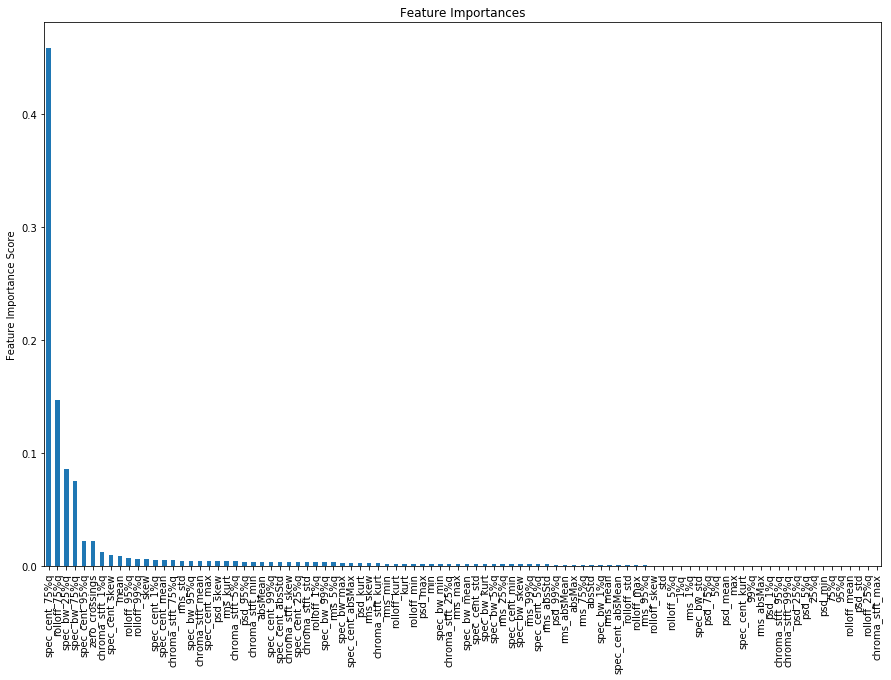

Top 20 Feature
['spec_cent_75%q', 'rolloff_75%q', 'spec_bw_25%q', 'spec_bw_75%q', 'spec_cent_95%q', 'zero_crossings', 'chroma_stft_1%q', 'spec_cent_skew', 'mean', 'rolloff_95%q', 'rolloff_99%q', 'skew', 'spec_cent_1%q', 'spec_cent_mean', 'chroma_stft_75%q', 'rms_std', 'spec_bw_95%q', 'chroma_stft_mean', 'spec_cent_max', 'psd_skew']


In [9]:
gbm0 = GradientBoostingRegressor(random_state=10)
modelfit(gbm0, feature_data, time_to_failure)

# Parameter Tuning

 Tune tree based and boosting parameters

## Tree based parameter

Fix learning rate and number of estimators for tuning tree-based parameters

### Determine the optimum number of trees and learning rate arround to tune tree based parameter

In [26]:
param_test1 = {'n_estimators':range(40,121,10)}

Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
subsample = 0.8 : This is a commonly used used start value

In [27]:
min_samples_split = int(feature_data.shape[0]*0.008)

estimator = GradientBoostingRegressor(
            learning_rate=0.1, 
            min_samples_split=500,
            min_samples_leaf=50,
            max_depth=8,
            max_features='sqrt',
            subsample=0.8,
            random_state=10)

gsearch1 = GridSearchCV(
    estimator = estimator,
    param_grid = param_test1, 
    scoring='neg_mean_absolute_error',
    iid=False,
    n_jobs=-1,
    cv=5)
                        
gsearch1.fit(feature_data,time_to_failure)

print('Best params {}'.format(gsearch1.best_params_))
print('Best MAE score: {}'.format(gsearch1.best_score_))

Best params {'n_estimators': 50}
Best MAE score: -2.0736380279860627


learning-rate verringern, damit die Anzahl Bäume steigt

### Tuning tree-specific parameters

In [28]:
n_estimators = 50
learning_rate = 0.1

### Tune max_depth and num_samples_split

In [32]:
param_test2 = {'max_depth':range(2,16,2), 'min_samples_split':range(2,12,1)}

gsearch2 = GridSearchCV(
    estimator = GradientBoostingRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_features='sqrt', 
        subsample=0.8, 
        random_state=10), 
    param_grid = param_test2, 
    scoring='neg_mean_absolute_error',
    iid=False,
    n_jobs=-1,
    cv=5)
gsearch2.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch2.best_params_))
print('Best MAE score: {}'.format(gsearch2.best_score_))

Best params {'max_depth': 4, 'min_samples_split': 10}
Best MAE score: -2.0698148309744027


In [33]:
max_depth = 4
min_samples_split = 10

Tune min_samples_leaf

In [35]:
param_test3 = {'min_samples_leaf':range(40,80,10)}
gsearch3 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            learning_rate=learning_rate, 
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features='sqrt', 
                            subsample=0.8, 
                            random_state=10), 
                            param_grid = 
                            param_test3,
                            scoring='neg_mean_absolute_error',
                            iid=False,
                            n_jobs=-1,
                            cv=5)
gsearch3.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch3.best_params_))
print('Best MAE score: {}'.format(gsearch3.best_score_))

Best params {'min_samples_leaf': 60}
Best MAE score: -2.0696775663236036


In [36]:
min_samples_leaf=60


Model Report
MAE train data: 1.929
CV Score MAE: 
Mean -2.069678 
Std 0.06507645 
Min -2.16813 
Max -1.988281


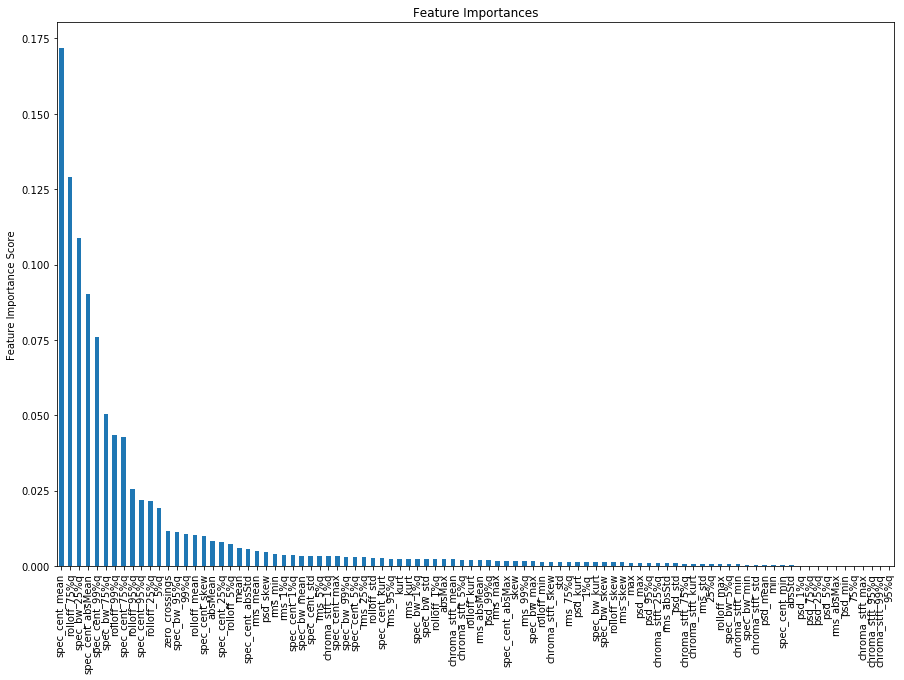

Top 20 Feature
['spec_cent_mean', 'rolloff_75%q', 'spec_bw_25%q', 'spec_cent_absMean', 'spec_cent_99%q', 'spec_bw_75%q', 'rolloff_99%q', 'spec_cent_75%q', 'rolloff_95%q', 'spec_cent_95%q', 'rolloff_25%q', '5%q', 'zero_crossings', 'spec_bw_95%q', '99%q', 'rolloff_mean', 'spec_cent_skew', 'absMean', 'spec_cent_25%q', 'rolloff_5%q']


In [37]:
modelfit(gsearch3.best_estimator_,  feature_data, time_to_failure)

Jetzt werden mehrere Varibeln für die Entscheidung berücksichtigt!

Tune max_features

In [39]:
param_test4 = {'max_features':range(10,30,2)}
gsearch4 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            learning_rate=learning_rate, 
                            n_estimators=n_estimators,
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            subsample=0.8,
                            random_state=10),
                            param_grid = param_test4, 
                            scoring='neg_mean_absolute_error',
                            iid=False,
                            n_jobs=-1,
                            cv=5)
gsearch4.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch4.best_params_))
print('Best MAE score: {}'.format(gsearch4.best_score_))

Best params {'max_features': 20}
Best MAE score: -2.064156532226979


In [40]:
max_features = 20

 Take the variables with a higher impact on outcome first
  - Tune max_depth and num_samples_split
  - Tune min_samples_leaf
  - Tune max_features

### Tuning subsample

In [41]:
param_test5 = {'subsample':[0.65,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            random_state=10,
                            max_features=max_features),
                            param_grid = param_test5,
                            scoring='neg_mean_absolute_error',
                            iid=False,
                            n_jobs=-1,
                            cv=5)
gsearch5.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch5.best_params_))
print('Best MAE score: {}'.format(gsearch5.best_score_))

Best params {'subsample': 0.8}
Best MAE score: -2.064156532226979


In [42]:
subsample = 0.8

### Tune learning_rate and n_estimators

In [43]:
param_test6 = {'learning_rate':[0.1],'n_estimators' :[50]}
gsearch6 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            subsample=subsample,
                            random_state=10),
                        param_grid = param_test6,
                        scoring='neg_mean_absolute_error',
                        iid=False,
                        n_jobs=-1,
                        cv=5)

gsearch6.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch6.best_params_))
print('Best MAE score: {}'.format(gsearch6.best_score_))

Best params {'learning_rate': 0.1, 'n_estimators': 50}
Best MAE score: -2.064156532226979


In [51]:
param_test7 = {'learning_rate':[0.005],'n_estimators' :[1000]}
gsearch7 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            subsample=subsample,
                            random_state=10),
                        param_grid = param_test7,
                        scoring='neg_mean_absolute_error',
                        iid=False,
                        n_jobs=-1,
                        cv=5)

gsearch7.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch7.best_params_))
print('Best MAE score: {}'.format(gsearch7.best_score_))

Best params {'learning_rate': 0.005, 'n_estimators': 1000}
Best MAE score: -2.065185452236425



Model Report
MAE train data: 1.898
CV Score MAE: 
Mean -2.065185 
Std 0.06838584 
Min -2.171549 
Max -1.990168


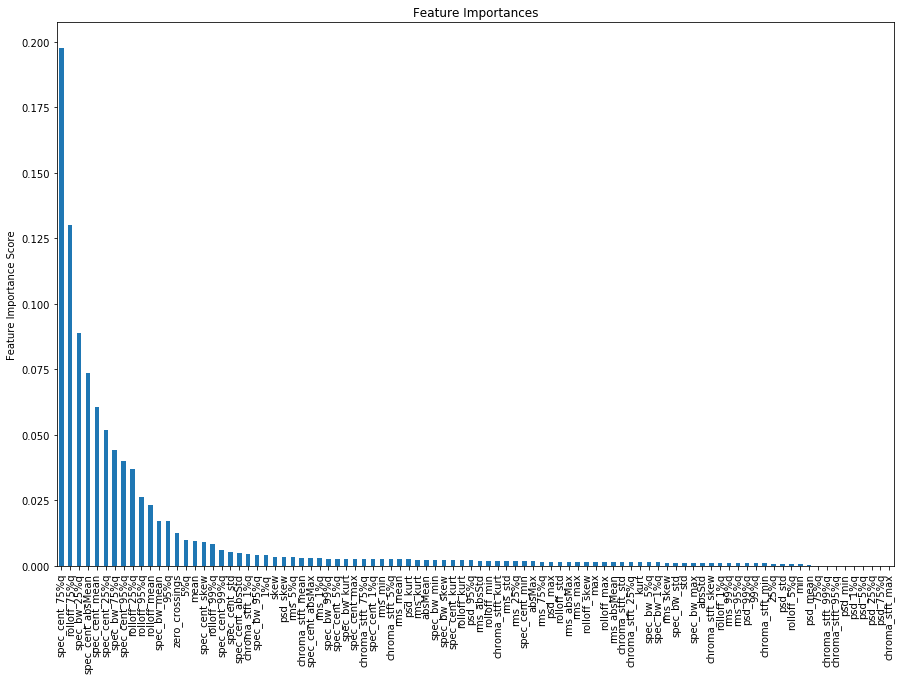

Top 20 Feature
['spec_cent_75%q', 'rolloff_75%q', 'spec_bw_25%q', 'spec_cent_absMean', 'spec_cent_mean', 'spec_cent_25%q', 'spec_bw_75%q', 'spec_cent_95%q', 'rolloff_25%q', 'rolloff_95%q', 'rolloff_mean', 'spec_bw_mean', '95%q', 'zero_crossings', '5%q', 'mean', 'spec_cent_skew', 'rolloff_99%q', 'spec_cent_99%q', 'spec_cent_std']


In [52]:
modelfit(gsearch7.best_estimator_,  feature_data, time_to_failure)

# Model Test 4194 20 Feature

In [53]:
train_data = pd.read_csv(earthquake_daten+feature_41934_94)
train_data = shuffle(train_data, random_state=10)
feature_data = train_data.iloc[:,1:95]
time_to_failure = np.array(train_data.iloc[:,-1])

In [54]:
feature_data.shape

(41934, 94)


Model Report
MAE train data: 1.971
CV Score MAE: 
Mean -1.999156 
Std 0.008063953 
Min -2.010264 
Max -1.989626


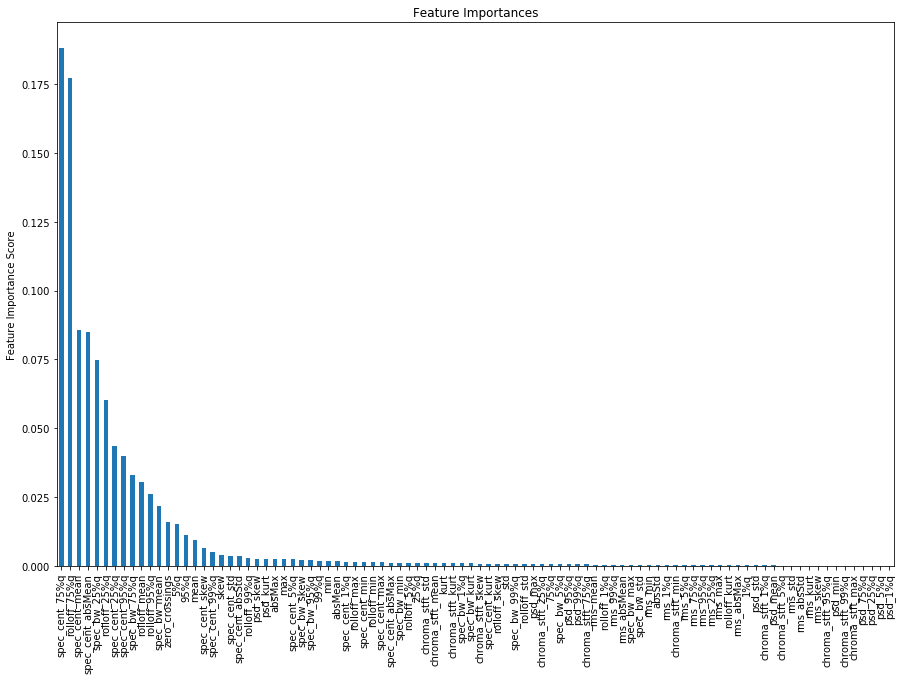

Top 20 Feature
['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_mean', 'spec_cent_absMean', 'spec_bw_25%q', 'rolloff_25%q', 'spec_cent_25%q', 'spec_cent_95%q', 'spec_bw_75%q', 'rolloff_mean', 'rolloff_95%q', 'spec_bw_mean', 'zero_crossings', '5%q', '95%q', 'mean', 'spec_cent_skew', 'spec_cent_99%q', 'skew', 'spec_cent_std']


In [55]:
modelfit(gsearch7.best_estimator_,  feature_data, time_to_failure)